## Loading track2p results 

In [2]:
# imports
import os
from types import SimpleNamespace
import matplotlib.pyplot as plt
import pandas as pd
import csv
import matplotlib.colors as mcolors
import numpy as np

In [7]:
t2p_save_path = '/Volumes/data_jm_share/data_proc/jm/jm046/chan1'  # (change this based on your data)
save_path='/Volumes/data_jm_share/data_proc/jm/jm046'
plane = 'plane0' # which plane to process (the example dataset is single-plane)

In [10]:
# np.load() the match matrix (plane0_match_mat.npy)
t2p_match_mat = np.load(os.path.join(t2p_save_path,'track2p', f'{plane}_match_mat.npy'), allow_pickle=True)

# np.load() settings (this contains suite2p paths etc.) (track_ops.npy)
track_ops_dict = np.load(os.path.join(t2p_save_path, 'track2p', 'track_ops.npy'), allow_pickle=True).item()
track_ops = SimpleNamespace(**track_ops_dict) # create dummy object from the track_ops dictionary

print(t2p_save_path)
print(track_ops.save_path)
print(track_ops.reg_chan)
print(track_ops.transform_type)
print(t2p_match_mat.shape)
print(t2p_match_mat)

/Volumes/data_jm_share/data_proc/jm/jm046/chan1
/Volumes/data_jm_share/data_proc/jm/jm046/t2p_chan1/track2p/
1
affine
(1878, 7)
[[None None None ... None None None]
 [1 625 424 ... None None None]
 [2 8 2 ... None None None]
 ...
 [1875 2180 1306 ... 1405 1269 None]
 [None None None ... None None None]
 [1877 535 None ... None None None]]


[[False False False ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ...  True  True False]
 [False False False ... False False False]
 [ True  True False ... False False False]]


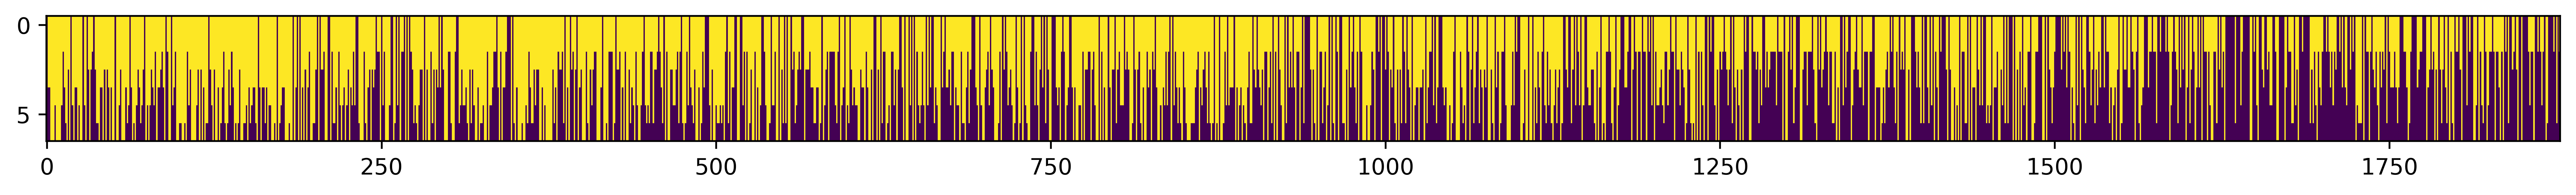

In [11]:
t2p_match_mat_notnone = t2p_match_mat != None #bolean matrix
print(t2p_match_mat_notnone)
plt.figure(figsize=(20, 1), dpi=500)
plt.imshow(t2p_match_mat_notnone.T, aspect='auto', vmin=0, vmax=1)


In [12]:
print('Datasets used for t2p:\n')
for ds_path in track_ops.all_ds_path:
    iscell=np.load(os.path.join(ds_path,'suite2p', 'plane0','iscell.npy'))
    iscell = iscell[iscell[:, 0] > track_ops.iscell_thr]
    print(len(iscell))


Datasets used for t2p:

1878
2267
2040
2287
1753
1728
1444


## Above is the output of the algorithm, now generate ground truth
### Generate grid

In [13]:
# load the suite2p output of the first dataset
s2p_path = os.path.join(track_ops.all_ds_path[0], 'suite2p', plane)
print(track_ops.all_ds_path)

# load the ops and stat
ops_first = np.load(os.path.join(s2p_path, 'ops.npy'), allow_pickle=True).item()
stat_first = np.load(os.path.join(s2p_path, 'stat.npy'), allow_pickle=True)
iscell_first = np.load(os.path.join(s2p_path, 'iscell.npy'), allow_pickle=True)
s2p_inds = np.arange(len(stat_first))

# filter stat based on the track2p probability
print(f'Filtering stat based on the track2p probability (iscell_thr={track_ops.iscell_thr})')
s2p_inds_iscell = s2p_inds[iscell_first[:, 0] > track_ops.iscell_thr]
stat_first_iscell = stat_first[iscell_first[:, 0] > track_ops.iscell_thr]
print(f'Filtered stat from {len(stat_first)} to {len(stat_first_iscell)} cells')



['/Volumes/data_jm_share/data_proc/jm/jm046/2024-09-03_a', '/Volumes/data_jm_share/data_proc/jm/jm046/2024-09-04_a', '/Volumes/data_jm_share/data_proc/jm/jm046/2024-09-05_a', '/Volumes/data_jm_share/data_proc/jm/jm046/2024-09-06_a', '/Volumes/data_jm_share/data_proc/jm/jm046/2024-09-07_a', '/Volumes/data_jm_share/data_proc/jm/jm046/2024-09-08_a', '/Volumes/data_jm_share/data_proc/jm/jm046/2024-09-09_a']
Filtering stat based on the track2p probability (iscell_thr=0.5)
Filtered stat from 3079 to 1878 cells


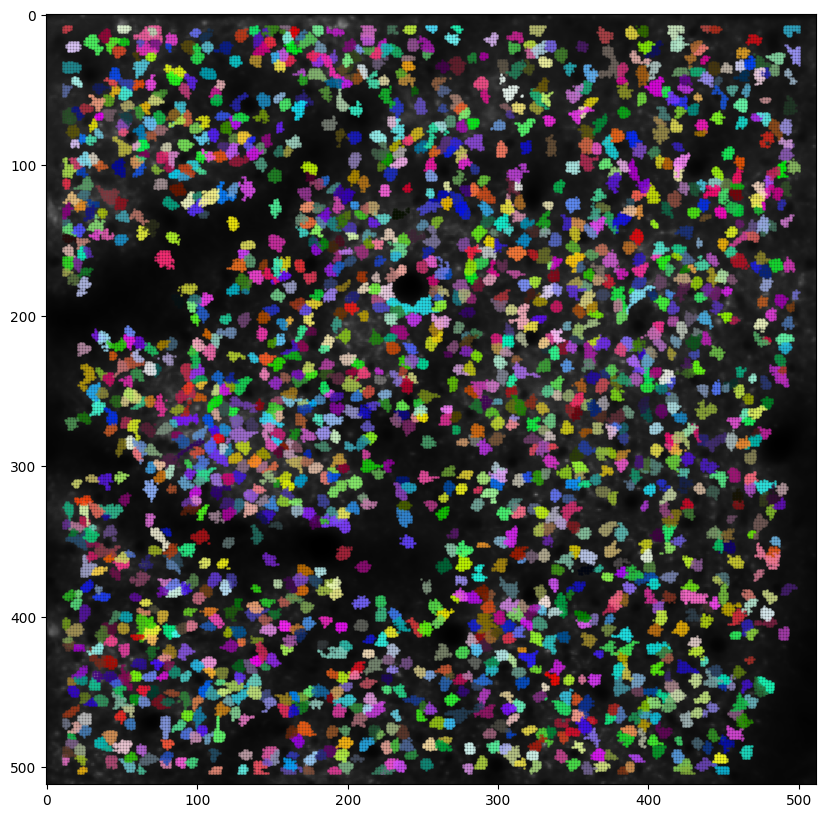

In [14]:
# now plot the fov with contours
plt.figure(figsize=(10, 10))
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(len(stat_first_iscell)):
    # get random color 
    color = np.random.rand(3)
    plt.scatter(stat_first_iscell[i]['xpix'], stat_first_iscell[i]['ypix'], s=1, color=color, alpha=0.5)

(-0.5, 511.5, 511.5, -0.5)

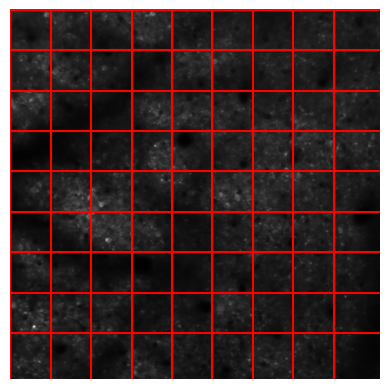

In [15]:
# now make a 8x8 grid on the image
n_grid = 9
grid_x = np.arange(0, ops_first['meanImg'].shape[1], ops_first['meanImg'].shape[1] // n_grid)
grid_y = np.arange(0, ops_first['meanImg'].shape[0], ops_first['meanImg'].shape[0] // n_grid)

plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='r')
    plt.axhline(grid_y[i], color='r')

plt.axis('off')

In [16]:
# now for each grid cross get the nearest cell (except for 0 and 512 pixels)
all_cell_med = []

# get all cell medians from stat
for i in range(len(stat_first_iscell)):
    all_cell_med.append(stat_first_iscell[i]['med'])
    

In [17]:
# compute coordinates of the grid crosses
grid_crosses = []
for i in range(1, n_grid):
    for j in range(1, n_grid):
        grid_crosses.append((grid_x[i], grid_y[j]))

In [18]:
grid_crosses

[(56, 56),
 (56, 112),
 (56, 168),
 (56, 224),
 (56, 280),
 (56, 336),
 (56, 392),
 (56, 448),
 (112, 56),
 (112, 112),
 (112, 168),
 (112, 224),
 (112, 280),
 (112, 336),
 (112, 392),
 (112, 448),
 (168, 56),
 (168, 112),
 (168, 168),
 (168, 224),
 (168, 280),
 (168, 336),
 (168, 392),
 (168, 448),
 (224, 56),
 (224, 112),
 (224, 168),
 (224, 224),
 (224, 280),
 (224, 336),
 (224, 392),
 (224, 448),
 (280, 56),
 (280, 112),
 (280, 168),
 (280, 224),
 (280, 280),
 (280, 336),
 (280, 392),
 (280, 448),
 (336, 56),
 (336, 112),
 (336, 168),
 (336, 224),
 (336, 280),
 (336, 336),
 (336, 392),
 (336, 448),
 (392, 56),
 (392, 112),
 (392, 168),
 (392, 224),
 (392, 280),
 (392, 336),
 (392, 392),
 (392, 448),
 (448, 56),
 (448, 112),
 (448, 168),
 (448, 224),
 (448, 280),
 (448, 336),
 (448, 392),
 (448, 448)]

(-0.5, 511.5, 511.5, -0.5)

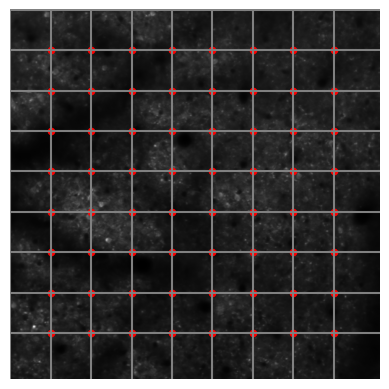

In [19]:
plt.imshow(ops_first['meanImg'], cmap='gray')
for i in range(n_grid):
    plt.axvline(grid_x[i], color='gray')
    plt.axhline(grid_y[i], color='gray')
for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='r')

plt.axis('off')


In [20]:
# compute distances between each cell and each grid cross
distances = np.zeros((len(stat_first_iscell), len(grid_crosses)))
for i, cell_med in enumerate(all_cell_med):
    for j, cross in enumerate(grid_crosses):
        distances[i, j] = np.sqrt((cell_med[0] - cross[0])**2 + (cell_med[1] - cross[1])**2)

In [21]:
# now get the nearest cell for each grid cross
nearest_cells = np.argmin(distances, axis=0)

In [22]:
nearest_cells

array([  94, 1436, 1402, 1726,  161, 1594,  503, 1364, 1401, 1016,  888,
        288,  504,  695, 1273,  417, 1114, 1454,  748, 1768,  731,  458,
        485, 1592, 1380,  424, 1802,   77, 1702, 1728, 1663, 1877,  383,
         32, 1090, 1230,  440,  908,  212,  226, 1675, 1661,  181, 1383,
        423, 1477, 1690, 1732,  635, 1062,  946, 1301,  795,  858, 1642,
       1586,  241,  361,  454, 1302, 1784, 1376,  249, 1056])

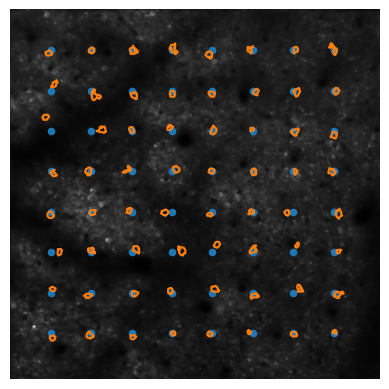

In [23]:
plt.imshow(ops_first['meanImg'], cmap='gray')

for cross in grid_crosses:
    plt.scatter(cross[0], cross[1], s=20, color='C0')

plt.axis('off')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')

In [24]:
# now get the original indices
original_indices = s2p_inds_iscell[nearest_cells]
print('Now open suite2p and try to manually track cells:')
[print(f'{original_indices[i]}') for i in range(len(original_indices))]

Now open suite2p and try to manually track cells:
99
2097
2029
2695
172
2419
614
1952
2025
1361
1173
322
615
880
1778
491
1522
2143
954
2809
923
549
586
2417
1979
501
2899
81
2640
2701
2555
3075
445
32
1484
1708
525
1198
227
242
2582
2551
194
1983
500
2186
2617
2722
790
1442
1248
1823
1024
1121
2507
2405
259
417
544
1824
2858
1972
272
1428


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

(-0.5, 511.5, 511.5, -0.5)

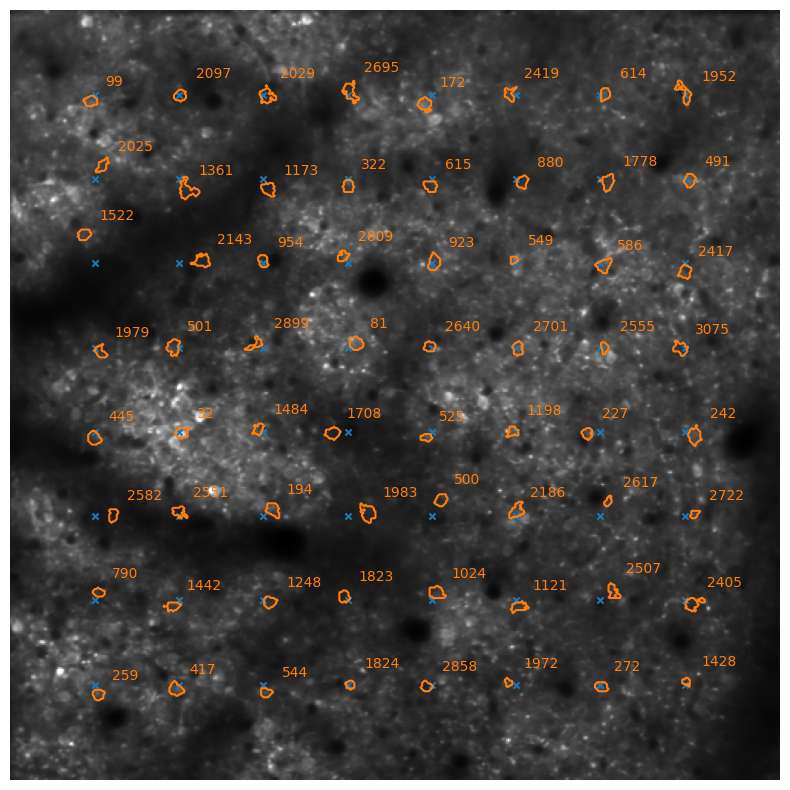

In [25]:
# make the same plot as above but with numbers labeled next to the roi
plt.figure(figsize=(10, 10))
# clip based on 99.99 percentile
img = ops_first['meanImg'].copy()
img[img > np.percentile(img, 99.99)] = np.percentile(img, 99.99)
plt.imshow(img, cmap='gray')

for i, cell in enumerate(nearest_cells):
    roi = np.zeros_like(ops_first['meanImg'])
    roi[stat_first_iscell[cell]['ypix'], stat_first_iscell[cell]['xpix']] = 1
    plt.contour(roi, levels=[0.5], colors='C1')
    plt.text(stat_first_iscell[cell]['med'][1]+10, stat_first_iscell[cell]['med'][0]-10, f'{original_indices[i]}', color='C1')
    plt.scatter(grid_crosses[i][0], grid_crosses[i][1], s=20, color='C0', marker='x')

plt.axis('off')

In [26]:
np.sort(original_indices)

array([  32,   81,   99,  172,  194,  227,  242,  259,  272,  322,  417,
        445,  491,  500,  501,  525,  544,  549,  586,  614,  615,  790,
        880,  923,  954, 1024, 1121, 1173, 1198, 1248, 1361, 1428, 1442,
       1484, 1522, 1708, 1778, 1823, 1824, 1952, 1972, 1979, 1983, 2025,
       2029, 2097, 2143, 2186, 2405, 2417, 2419, 2507, 2551, 2555, 2582,
       2617, 2640, 2695, 2701, 2722, 2809, 2858, 2899, 3075])

### Getting real suite2p indexes to compare it to

In [6]:
def function(path, plane):

    track_ops_dict = np.load(os.path.join(path, "track2p", "track_ops.npy"), allow_pickle=True).item()
    track_ops = SimpleNamespace(**track_ops_dict)
    t2p_match_mat = np.load(os.path.join(path,"track2p" ,f"{plane}_match_mat.npy"), allow_pickle=True)
    #t2p_match_mat_allday = t2p_match_mat
    
    if track_ops.iscell_thr is not None:
        true_indices= np.empty((len(t2p_match_mat), len(track_ops.all_ds_path)), dtype=object)
        
    for j in range(len(t2p_match_mat)):
        for (i, ds_path) in enumerate(track_ops.all_ds_path):
            iscell = np.load(os.path.join(ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)
            if track_ops.iscell_thr is not None:
                s2p_indexes= np.where(iscell[:,1]>track_ops.iscell_thr)[0]
                t2p_index=t2p_match_mat[j,i]

                if t2p_index is None:
                    true_index = None
                else:
                    true_index=s2p_indexes[t2p_index]

                true_indices[j, i] = true_index
            else:
                pass
    if track_ops.iscell_thr is not None:        
        np.save(os.path.join(path, "true_indices.npy"), true_indices)
        print("saved")
    else:
        print("not in locals")
        
function(t2p_save_path, plane)  

indices_npy= np.load(os.path.join(t2p_save_path,"true_indices.npy"), allow_pickle=True)
print(indices_npy)
print(indices_npy.shape)

#indices_npy (index of the cell in the suite2p output)

In [247]:
# index rows for cells where the first row is in original_indices
all_s2p_idxs = []
for idx in np.sort(original_indices):
    idx_row = np.where(indices_npy[:,0]==idx)
    print(idx_row)

    if len(idx_row[0]) == 0:
        s2p_idxs = [None]*len(track_ops.all_ds_path)
        #print('here')

    else:
        s2p_idxs = indices_npy[idx_row]
    all_s2p_idxs.append(s2p_idxs[0])

all_s2p_idxs = np.array(all_s2p_idxs)

#print(all_s2p_idxs.dtype)
print(f'all_s2p_idxs {all_s2p_idxs}')

(array([32]),)
(array([77]),)
(array([], dtype=int64),)
(array([161]),)
(array([181]),)
(array([212]),)
(array([226]),)
(array([241]),)
(array([249]),)
(array([288]),)
(array([361]),)
(array([383]),)
(array([417]),)
(array([423]),)
(array([424]),)
(array([440]),)
(array([454]),)
(array([458]),)
(array([485]),)
(array([503]),)
(array([504]),)
(array([635]),)
(array([695]),)
(array([731]),)
(array([748]),)
(array([795]),)
(array([858]),)
(array([888]),)
(array([908]),)
(array([946]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([1062]),)
(array([1090]),)
(array([1114]),)
(array([1230]),)
(array([1273]),)
(array([1301]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([1376]),)
(array([1380]),)
(array([1383]),)
(array([1401]),)
(array([1402]),)
(array([1436]),)
(array([1454]),)
(array([1477]),)
(array([1586]),)
(array([1592]),)
(array([1594]),)
(array([], dtype=int64),)
(array([1661]),)
(array([], dtype=int64),)
(array([1675]),)
(array([], dtype=int64),)
(array(

/var/folders/95/8rmbkst12z960tdjyz8xj_h40000gn/T/ipykernel_43165/1505591388.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_s2p_idxs = np.array(all_s2p_idxs)


### Loading and processing cellreg outputs

In [ ]:
# Create .mat files for cellreg from suite2p outputs

import numpy as np
import os
from scipy.io import savemat
import os
import numpy as np
import matplotlib.colors as mcolors
import random
from types import SimpleNamespace

for (i, ds_path) in enumerate(track_ops.all_ds_path):
    stat = np.load(os.path.join(ds_path, 'suite2p', f'plane{plane}' ,'stat.npy'), allow_pickle=True)
    iscell = np.load(os.path.join(ds_path, 'suite2p', f'plane{plane}', 'iscell.npy'), allow_pickle=True)
    ops = np.load(os.path.join(ds_path, 'suite2p', f'plane{plane}', 'ops.npy'), allow_pickle=True).item()


    Ly, Lx = int(ops['Ly']), int(ops['Lx'])


    N = int(np.sum(iscell[:, 0]))

    footprints = np.zeros((N, Ly, Lx))


    neuron_idx = 0
    for i, s in enumerate(stat):
        if iscell[i, 0]: 
            footprints[neuron_idx, s['ypix'], s['xpix']] = s['lam']
            neuron_idx += 1


    print(f"Footprints shape: {footprints.shape}")

    footprints_part1 = footprints[:N//2]
    footprints_part2 = footprints[N//2:]


    savemat(os.path.join(ds_path,"footprints_part1.mat"), 
        {'footprints_part1': footprints_part1})

    savemat(os.path.join(ds_path,"footprints_part2.Mat"), 
        {'footprints_part2': footprints_part2})


In [251]:
import h5py

# this is the directory that contains a /track2p folder that is output by running the track2p algorithm
cellreg_path = os.path.join(save_path, 'cellreg')
print(cellreg_path)

with h5py.File(os.path.join(cellreg_path, "cellRegistered.mat"), 'r') as f:
    # Accéder au dataset spécifique
    cell_to_index_map = f['cell_registered_struct/cell_to_index_map']
 
    cell_to_index_map = np.array(cell_to_index_map)
    print(cell_to_index_map.shape)

    # Filtrer les colonnes où la première ligne n'est pas égale à 0
    # Pour avoir la même shape que le tableau de match de track2p (autant de lignes que dans iscell > 0.5 du jour 1)
    mask0 = cell_to_index_map[0, :] != 0
    filtered_cell_to_index_map = cell_to_index_map[:, mask0]
    print(filtered_cell_to_index_map.astype(int))

    # Convertir en entier
    filtered_cell_to_index_map = filtered_cell_to_index_map.astype(int)

    # Remplacer les zéros par None et décrémenter les autres chiffres de 1
    filtered_cell_to_index_map = np.where(filtered_cell_to_index_map == 0, None, filtered_cell_to_index_map - 1)
    print(filtered_cell_to_index_map)

    # Enregistrer le tableau modifié
    np.save(os.path.join(cellreg_path, "plane0_match_mat_cellreg.npy"), filtered_cell_to_index_map)
    print("NumPy file 'plane0_match_mat_cellreg.npy' created successfully.")

    # Charger et afficher le fichier NumPy modifié
    cellreg_match_mat = np.load(os.path.join(cellreg_path, "plane0_match_mat_cellreg.npy"), allow_pickle=True)
    print(cellreg_match_mat)
    print(cellreg_match_mat.shape)

/Volumes/data_jm_share/data_proc/jm/jm046/cellreg
(7, 9561)
[[  1   4   5 ... 442 583 931]
 [  0  10  55 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0 309 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]
[[0 3 4 ... 441 582 930]
 [None 9 54 ... None None None]
 [None None None ... None None None]
 ...
 [None None 308 ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]]
NumPy file 'plane0_match_mat_cellreg.npy' created successfully.
[[0 3 4 ... 441 582 930]
 [None 9 54 ... None None None]
 [None None None ... None None None]
 ...
 [None None 308 ... None None None]
 [None None None ... None None None]
 [None None None ... None None None]]
(7, 1878)


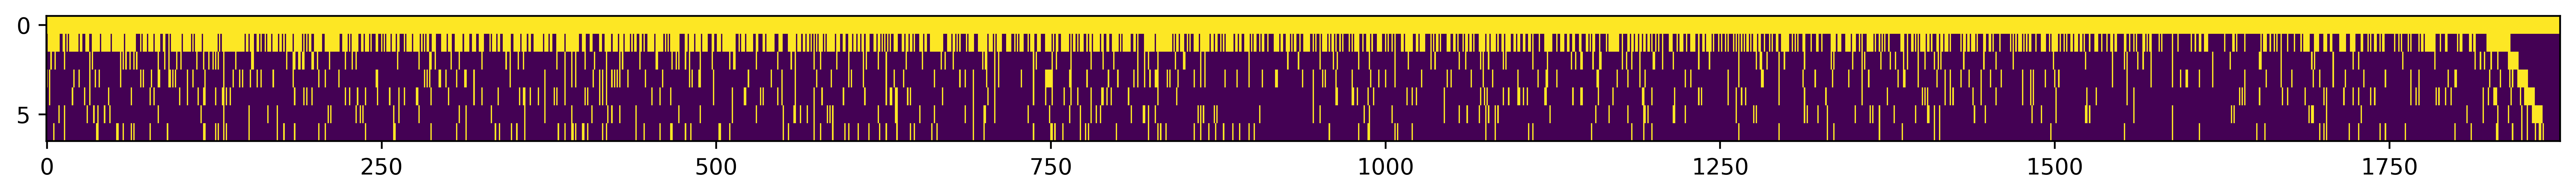

In [252]:
# Afficher le tableau modifié avec plt.imshow
bool_array = np.where(cellreg_match_mat == None, 0, 1).astype(bool)
plt.figure(figsize=(20, 1), dpi=500)
plt.imshow(bool_array,  aspect='auto', vmin=0, vmax=1)
plt.show()

In [253]:
cellreg_match_mat = cellreg_match_mat.T

In [254]:
cellreg_match_mat

array([[0, None, None, ..., None, None, None],
       [3, 9, None, ..., None, None, None],
       [4, 54, None, ..., 308, None, None],
       ...,
       [441, None, None, ..., None, None, None],
       [582, None, None, ..., None, None, None],
       [930, None, None, ..., None, None, None]], dtype=object)

In [255]:
for i in range(len(cellreg_match_mat)):
    if all(x is None for x in cellreg_match_mat[i][1:]):
        cellreg_match_mat[i] = None

In [256]:
cellreg_match_mat

array([[0, None, None, ..., None, None, None],
       [3, 9, None, ..., None, None, None],
       [4, 54, None, ..., 308, None, None],
       ...,
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None],
       [None, None, None, ..., None, None, None]], dtype=object)

In [ ]:
# For same as t2p_match_mat
for i in range(len(cellreg_match_mat)):
    if cellreg_match_mat[i,1] is None:
        cellreg_match_mat[i] = None

#ne pas faire si cellreg pairs

#### Getting real suite2p indexes to compare it to

In [257]:
def function_cellreg(path, plane):

    if track_ops.iscell_thr is not None:
        true_indices= np.empty(cellreg_match_mat.shape, dtype=object)
        print(true_indices.shape)
        
    for (i, ds_path) in enumerate(track_ops.all_ds_path):
        iscell = np.load(os.path.join(ds_path, 'suite2p', plane, 'iscell.npy'), allow_pickle=True)
        s2p_indexes= np.where(iscell[:,1]>track_ops.iscell_thr)[0]
        #print(s2p_indexes)
        print(f'suite2P {len(s2p_indexes)}')
        for j in range(cellreg_match_mat.shape[0]):
                if track_ops.iscell_thr is not None:
                    cellreg_index=cellreg_match_mat[j,i]
                    print(cellreg_index)

                if cellreg_index is None :
                    true_index = None
                else:
                    true_index=s2p_indexes[cellreg_index]

                true_indices[j, i] = true_index
        else:
            pass
    if track_ops.iscell_thr is not None:        
        np.save(os.path.join(path, "true_indices_cellreg.npy"), true_indices)
        print("saved")
    else:
        print("not in locals")
        
function_cellreg(cellreg_path, plane)  

indices_cellreg_npy= np.load(os.path.join(cellreg_path,"true_indices_cellreg.npy"), allow_pickle=True)
print(indices_cellreg_npy)
print(indices_cellreg_npy.shape)


(1878, 7)
suite2P 1878
0
3
4
5
6
7
8
9
10
11
None
None
14
15
None
17
None
19
20
22
23
24
25
26
27
28
29
None
31
32
33
34
35
None
37
38
39
40
41
42
None
44
45
46
47
48
49
50
None
52
53
54
55
56
57
59
60
61
None
63
64
65
66
67
68
69
70
71
None
None
74
None
76
77
78
None
80
81
82
83
84
85
86
87
88
None
None
91
92
None
94
95
96
97
98
99
100
101
102
103
104
None
106
107
108
109
110
112
None
114
None
116
117
118
119
120
None
122
123
124
125
126
127
128
130
131
132
133
134
135
None
139
140
141
142
143
145
146
147
148
149
150
152
153
154
155
156
157
None
159
160
161
162
163
165
None
None
168
169
None
171
None
None
174
None
176
177
178
None
180
181
182
183
None
185
186
None
188
None
190
191
192
193
194
195
196
197
198
199
200
201
202
203
None
206
None
208
209
210
211
212
213
214
215
216
217
None
None
220
221
222
223
224
225
226
227
228
229
230
None
None
233
234
235
236
None
238
None
240
241
242
243
244
None
247
248
249
None
251
252
253
None
255
None
None
None
259
260
None
None
264
None
266
None

In [258]:
# index rows for cells where the first row is in original_indices
all_s2p_idxs_cellreg = []
for idx in np.sort(original_indices):
    idx_row = np.where(indices_cellreg_npy[:,0]==idx)
    print(idx_row)

    if len(idx_row[0]) == 0:
        s2p_idxs = [None]*len(track_ops.all_ds_path)
        #print('here')

    else:
        s2p_idxs = indices_cellreg_npy[idx_row]
    all_s2p_idxs_cellreg.append(s2p_idxs[0])

all_s2p_idxs_cellreg = np.array(all_s2p_idxs_cellreg)

#print(all_s2p_idxs.dtype)
print(all_s2p_idxs_cellreg)

(array([29]),)
(array([73]),)
(array([90]),)
(array([151]),)
(array([170]),)
(array([200]),)
(array([214]),)
(array([229]),)
(array([236]),)
(array([274]),)
(array([345]),)
(array([367]),)
(array([400]),)
(array([406]),)
(array([407]),)
(array([422]),)
(array([435]),)
(array([439]),)
(array([466]),)
(array([], dtype=int64),)
(array([485]),)
(array([614]),)
(array([674]),)
(array([710]),)
(array([727]),)
(array([772]),)
(array([833]),)
(array([862]),)
(array([882]),)
(array([918]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([1058]),)
(array([1082]),)
(array([1196]),)
(array([1238]),)
(array([1266]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([1340]),)
(array([1344]),)
(array([1347]),)
(array([], dtype=int64),)
(array([1366]),)
(array([1398]),)
(array([1415]),)
(array([1438]),)
(array([1542]),)
(array([1546]),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([1614]),)
(array([], dtype=int64),)
(array([1627]),)
(array(

/var/folders/95/8rmbkst12z960tdjyz8xj_h40000gn/T/ipykernel_43165/1711660874.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_s2p_idxs_cellreg = np.array(all_s2p_idxs_cellreg)


### Loading and processing 'ground truth' (csv table)

In [8]:
# load the data
print(save_path)
table = np.genfromtxt(os.path.join(save_path, 'ground_truth.csv'), delimiter=';', skip_header=1)
sorted_indices = np.argsort(table[:, 0])
table = table[sorted_indices]
table = np.where(np.isnan(table), None, table)
table = [[int(x) if x is not None else None for x in row] for row in table]
table

/Volumes/data_jm_share/data_proc/jm/jm046


[[32, 52, 8, 19, 3, 58, 99],
 [81, 223, 96, 692, 1733, None, None],
 [99, 1584, 883, 1088, 993, None, None],
 [172, None, None, None, None, None, None],
 [194, 322, 312, 230, 2115, 3034, None],
 [227, 72, 1251, 340, 113, 392, 135],
 [242, 1531, 46, 154, 1, 16, 21],
 [259, 593, 901, 152, 410, None, None],
 [272, 280, 164, 273, 244, 611, 1779],
 [322, 155, 137, 285, 263, 944, None],
 [417, 792, 1312, 1654, None, None, None],
 [445, 190, 187, None, None, None, None],
 [491, 536, 478, 97, 14, 19, 1097],
 [500, 756, 1014, 1031, 634, 532, 498],
 [501, 712, 515, 170, 617, 1566, None],
 [525, 2111, None, None, None, None, None],
 [544, 844, 1397, None, None, None, None],
 [549, 481, None, None, None, None, None],
 [586, 700, 152, 178, 93, 112, 190],
 [614, 513, 172, 206, 122, None, None],
 [615, 3130, 1100, 1702, 1941, 1561, None],
 [790, 312, 567, 643, 624, 616, None],
 [880, 2727, 102, 459, 316, None, None],
 [923, 2249, 737, 688, 2161, None, None],
 [954, 4208, 3182, None, None, None, None]

In [9]:
for i in range(len(table)):
    if all(x is None for x in table[i][1:]):
        table[i] = None


In [218]:
for i in range(len(table)):
    # print the rows
    print(f'track2p:     {all_s2p_idxs[i]}')
    print(f'manual:      {table[i]}')
    print('')

NameError: name 'all_s2p_idxs' is not defined

# Compute metrics

## For 'all days" registration

###  For 'all days' evaluation

In [ ]:
def compute_metrics_all_days(all_s2p_idxs, table, path):

    all_s2p_idxs_copy = all_s2p_idxs.copy()
    table_copy = table.copy()

# Because we want only cell present on all days 
    for i in range(len(table)):
        if all_s2p_idxs_copy[i] is not None:
            if any(x is None for x in all_s2p_idxs_copy[i]):
                all_s2p_idxs_copy[i] = None
        if table_copy[i] is not None:
            if any(x is None for x in table_copy[i]):
                table_copy[i] = None

        print(f'track2p:     {all_s2p_idxs_copy[i]}')
        print(f'manual:      {table_copy[i]}')


    FP_nb=0
    TP_nb=0
    FN_nb=0
    IS_nb=0
    TN_nb=0

    for i in range(len(table_copy)):
        if all_s2p_idxs_copy[i] is None and table_copy[i] is None:
                TN_nb +=1
        # if track2p detected on all days 
        elif all_s2p_idxs_copy[i] is None and table_copy[i] is not None:
                FN_nb +=1
        elif all_s2p_idxs_copy[i] is not None and table_copy[i] is None:
                FP_nb +=1
        elif all_s2p_idxs_copy[i] is not None and table_copy[i] is not None:
            if any((x!=y) for x, y in zip(all_s2p_idxs_copy[i], table_copy[i])):
                    IS_nb += 1
            else:
                    TP_nb +=1

    TP_rate= TP_nb/len(table)
    TN_rate= TN_nb/len(table)
    FP_rate= FP_nb/len(table)
    FN_rate= FN_nb/len(table)
    IS_rate= IS_nb/len(table)

    print(f'Sum of rates: {TP_rate + TN_rate + FP_rate + FN_rate + IS_rate:.2f}')


 # Calcul de la précision
    if (TP_nb + FP_nb + IS_nb) != 0:
        precision = TP_nb / (TP_nb + FP_nb + IS_nb)
    else:
        precision = 0

    # Calcul du rappel
    if (TP_nb + FN_nb) != 0:
        recall = TP_nb / (TP_nb + FN_nb)
    else:
        recall = 0

    # Calcul du F1-score
    if (precision + recall) != 0:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1: {f1}')

    metrics = np.array([
    ['TP', TP_rate],
    ['TN', TN_rate],
    ['FP', FP_rate],
    ['FN', FN_rate],
    ['IS', IS_rate],
    ['Precision', round(precision, 2)],
    ['Recall', round(recall, 2)],
    ['F1', round(f1, 2)]
    ], dtype=object)


    filename = os.path.join(path, 'metrics_t2p_all_days.npy')
    np.save(filename, metrics)
    print(f"NumPy file '{filename}' created successfully.")

In [ ]:
compute_metrics_all_days(all_s2p_idxs, table, t2p_save_path)

In [ ]:
metrics_t2p_all_days = np.load(os.path.join(t2p_save_path, 'metrics_t2p_all_days.npy'), allow_pickle=True)
print(metrics_t2p_all_days)

### For 'pairwise' evaluation

In [30]:
def calculate_metrics_pairs(manual_matches_elements,all_s2p_idxs_elements):
    
    FP_nb=0
    TP_nb=0
    FN_nb=0
    IS_nb=0
    TN_nb=0


    for i in range(len(manual_matches_elements)):
        if all_s2p_idxs_elements[i][1] is None  and manual_matches_elements[i][1] is None:
                TN_nb +=1

        
        # if track2p detected on all days 
        elif all_s2p_idxs_elements[i][1] is None and manual_matches_elements[i][1] is not None:
                FN_nb +=1
      
      
        elif all_s2p_idxs_elements[i][1] is not  None and manual_matches_elements[i][1] is None:
                FP_nb +=1
    
        elif all_s2p_idxs_elements[i][1] is not None and manual_matches_elements[i][1] is not None:
            if all_s2p_idxs_elements[i][1] != manual_matches_elements[i][1]:
                    IS_nb += 1
            else:
                    TP_nb +=1
                    print (manual_matches_elements[i][1])
                    print (all_s2p_idxs_elements[i][1])
               


    TP_rate= TP_nb/len(table)
    TN_rate= TN_nb/len(table)
    FP_rate= FP_nb/len(table)
    FN_rate= FN_nb/len(table)
    IS_rate= IS_nb/len(table)

    print(f'TN: {TN_nb}')
    print(f'FN: {FN_nb}')

    print(f'Sum of rates: {TP_rate + TN_rate + FP_rate + FN_rate + IS_rate:.2f}')


 # Calcul de la précision
    if (TP_nb + FP_nb + IS_nb) != 0:
        precision = TP_nb / (TP_nb + FP_nb + IS_nb)
    else:
        precision = 0

    # Calcul du rappel
    if (TP_nb + FN_nb) != 0:
        recall = TP_nb / (TP_nb + FN_nb)
    else:
        recall = 0

    # Calcul du F1-score
    if (precision + recall) != 0:
        f1 = (2 * precision * recall) / (precision + recall)
    else:
        f1 = 0

    return [TP_rate, TN_rate, FP_rate, FN_rate, IS_rate, precision, recall, f1]

  


#### track2p

In [248]:
metrics_names = ['TP', 'TN', 'FP', 'FN', 'IS', 'Precision', 'Recall', 'F1']
nb_days = 7

results = np.empty((len(metrics_names), nb_days), dtype=object)
results[:, 0] = metrics_names

print(results)

[['TP' None None None None None None]
 ['TN' None None None None None None]
 ['FP' None None None None None None]
 ['FN' None None None None None None]
 ['IS' None None None None None None]
 ['Precision' None None None None None None]
 ['Recall' None None None None None None]
 ['F1' None None None None None None]]


In [249]:
for day in range(1 , t2p_match_mat.shape[1]): 

    manual_matches_elements = [(sublist[0], sublist[day]) if sublist is not None and len(sublist) > day else (None, None) for sublist in table]
    all_s2p_idxs_elements = [(sublist[0], sublist[day]) if sublist is not None and len(sublist) > day else (None, None) for sublist in all_s2p_idxs]

    print("manual_matches_elements:", manual_matches_elements)
    print("all_s2p_idxs_elements:", all_s2p_idxs_elements)

    metrics = calculate_metrics_pairs(manual_matches_elements, all_s2p_idxs_elements)
    results[:, day] = metrics

np.save(os.path.join(t2p_save_path , 'metrics_table_pairs.npy'), results)



manual_matches_elements: [(32, 52), (81, 223), (99, 1584), (None, None), (194, 322), (227, 72), (242, 1531), (259, 593), (272, 280), (322, 155), (417, 792), (445, 190), (491, 536), (500, 756), (501, 712), (525, 2111), (544, 844), (549, 481), (586, 700), (614, 513), (615, 3130), (790, 312), (880, 2727), (923, 2249), (954, 4208), (1024, 1337), (1121, 1798), (1173, 269), (1198, 522), (1248, 909), (None, None), (None, None), (1442, 1316), (1484, 721), (1522, 1299), (1708, 1969), (1778, 258), (1823, 1974), (None, None), (None, None), (1972, 3504), (1979, 2597), (1983, 1348), (None, None), (2029, 3145), (2097, 287), (2143, 1789), (2186, 1819), (2405, 835), (2417, 4162), (2419, 836), (None, None), (2551, 1642), (None, None), (2582, 3069), (None, None), (None, None), (2695, 3188), (2701, 3820), (None, None), (None, None), (2858, 1880), (None, None), (3075, 560)]
all_s2p_idxs_elements: [(32, 52), (81, 223), (None, None), (172, 2589), (194, 322), (227, 72), (242, 1531), (259, 593), (272, 280), (

In [250]:
results_npy = np.load(os.path.join(t2p_save_path, 'metrics_table_pairs.npy'), allow_pickle=True)
print(results_npy)
print(t2p_save_path)

[['TP' 0.734375 0.625 0.390625 0.1875 0.109375 0.046875]
 ['TN' 0.171875 0.28125 0.34375 0.375 0.53125 0.6875]
 ['FP' 0.03125 0.03125 0.078125 0.109375 0.109375 0.078125]
 ['FN' 0.03125 0.03125 0.0625 0.15625 0.15625 0.109375]
 ['IS' 0.03125 0.03125 0.125 0.171875 0.09375 0.078125]
 ['Precision' 0.9215686274509803 0.9090909090909091 0.6578947368421053
  0.4 0.35 0.23076923076923078]
 ['Recall' 0.9591836734693877 0.9523809523809523 0.8620689655172413
  0.5454545454545454 0.4117647058823529 0.3]
 ['F1' 0.9400000000000001 0.9302325581395349 0.746268656716418
  0.4615384615384615 0.37837837837837834 0.2608695652173913]]
/Volumes/data_jm_share/data_proc/jm/jm046/t2p_chan1_rigid


#### cellreg

In [259]:
metrics_names = ['TP', 'TN', 'FP', 'FN', 'IS', 'Precision', 'Recall', 'F1']
nb_days = 7

results = np.empty((len(metrics_names), nb_days), dtype=object)
results[:, 0] = metrics_names

print(results)

[['TP' None None None None None None]
 ['TN' None None None None None None]
 ['FP' None None None None None None]
 ['FN' None None None None None None]
 ['IS' None None None None None None]
 ['Precision' None None None None None None]
 ['Recall' None None None None None None]
 ['F1' None None None None None None]]


In [260]:
for day in range(1, t2p_match_mat.shape[1]): 

    
    manual_matches_elements = [(sublist[0], sublist[day]) if sublist is not None and len(sublist) > day else (None, None) for sublist in table]
    all_cell_reg_elements = [(sublist[0], sublist[day]) if sublist is not None and len(sublist) > day else (None, None) for sublist in all_s2p_idxs_cellreg]

    print("manual_matches_elements:", manual_matches_elements)
    print("all_s2p_idxs_elements:", all_cell_reg_elements)

    metrics = calculate_metrics_pairs(manual_matches_elements, all_cell_reg_elements)
    results[:, day] = metrics

np.save(os.path.join(cellreg_path, 'metrics_table_pairs.npy'), results)
np.save(os.path.join(cellreg_path , 'metrics_table_pairs.npy'), results)

manual_matches_elements: [(32, 52), (81, 223), (99, 1584), (None, None), (194, 322), (227, 72), (242, 1531), (259, 593), (272, 280), (322, 155), (417, 792), (445, 190), (491, 536), (500, 756), (501, 712), (525, 2111), (544, 844), (549, 481), (586, 700), (614, 513), (615, 3130), (790, 312), (880, 2727), (923, 2249), (954, 4208), (1024, 1337), (1121, 1798), (1173, 269), (1198, 522), (1248, 909), (None, None), (None, None), (1442, 1316), (1484, 721), (1522, 1299), (1708, 1969), (1778, 258), (1823, 1974), (None, None), (None, None), (1972, 3504), (1979, 2597), (1983, 1348), (None, None), (2029, 3145), (2097, 287), (2143, 1789), (2186, 1819), (2405, 835), (2417, 4162), (2419, 836), (None, None), (2551, 1642), (None, None), (2582, 3069), (None, None), (None, None), (2695, 3188), (2701, 3820), (None, None), (None, None), (2858, 1880), (None, None), (3075, 560)]
all_s2p_idxs_elements: [(32, 52), (81, 223), (99, None), (172, None), (194, 322), (227, 72), (242, 1531), (259, 593), (272, 280), (32

In [261]:
results_npy = np.load(os.path.join(cellreg_path, 'metrics_table_pairs.npy'), allow_pickle=True)
print(results_npy)

[['TP' 0.6875 0.0 0.0 0.0 0.0 0.0]
 ['TN' 0.203125 0.296875 0.390625 0.4375 0.59375 0.703125]
 ['FP' 0.0 0.015625 0.03125 0.046875 0.046875 0.0625]
 ['FN' 0.09375 0.640625 0.53125 0.5 0.28125 0.171875]
 ['IS' 0.015625 0.046875 0.046875 0.015625 0.078125 0.0625]
 ['Precision' 0.9777777777777777 0.0 0.0 0.0 0.0 0.0]
 ['Recall' 0.88 0.0 0.0 0.0 0.0 0.0]
 ['F1' 0.9263157894736842 0 0 0 0 0]]


## For 'pairwise" registration

In [31]:
metrics_names = ['TP', 'TN', 'FP', 'FN', 'IS', 'Precision', 'Recall', 'F1']
nb_days = 7

results = np.empty((len(metrics_names), nb_days), dtype=object)
results[:, 0] = metrics_names

print(results)

[['TP' None None None None None None]
 ['TN' None None None None None None]
 ['FP' None None None None None None]
 ['FN' None None None None None None]
 ['IS' None None None None None None]
 ['Precision' None None None None None None]
 ['Recall' None None None None None None]
 ['F1' None None None None None None]]


In [32]:
import os
import numpy as np

path = "/Volumes/data_jm_share/data_proc/jm/jm046"
days = ['9', '10', '11', '12', '13', '14']
columns = []

for i, j in enumerate(days): 
    print(i)
    t2p_path = os.path.join(path, f't2p_P8_{j}')
    indices= function(t2p_path, 'plane0')
    indices=np.load(os.path.join(t2p_path, 'true_indices.npy'), allow_pickle=True)
    print(indices.shape)
    # index rows for cells where the first row is in original_indices
    all_s2p_idxs_pairs = []
    for idx in np.sort(original_indices):
        idx_row = np.where(indices[:,0]==idx)
        #print(idx_row)

        if len(idx_row[0]) == 0:
            s2p_idxs = [None]*len(track_ops.all_ds_path)
            #print('here')

        else:
            s2p_idxs = indices[idx_row]
        all_s2p_idxs_pairs.append(s2p_idxs[0])

    all_s2p_idxs_pairs = np.array(all_s2p_idxs_pairs)

    manual_matches_elements = [(sublist[0], sublist[i+1]) if sublist is not None  else (None, None) for sublist in table]
    all_s2p_idxs_elements = [(sublist[0], sublist[1]) if sublist is not None else (None, None) for sublist in all_s2p_idxs_pairs]
#
    print("manual_matches_elements:", manual_matches_elements)
    print("all_s2p_idxs_elements:", all_s2p_idxs_elements)

    metrics = calculate_metrics_pairs(manual_matches_elements, all_s2p_idxs_elements)
    results[:, i + 1] = metrics

np.save(os.path.join(path , 'metrics_table_pw_registration.npy'), results)


0
saved
(1878, 2)
manual_matches_elements: [(32, 52), (81, 223), (99, 1584), (None, None), (194, 322), (227, 72), (242, 1531), (259, 593), (272, 280), (322, 155), (417, 792), (445, 190), (491, 536), (500, 756), (501, 712), (525, 2111), (544, 844), (549, 481), (586, 700), (614, 513), (615, 3130), (790, 312), (880, 2727), (923, 2249), (954, 4208), (1024, 1337), (1121, 1798), (1173, 269), (1198, 522), (1248, 909), (None, None), (None, None), (1442, 1316), (1484, 721), (1522, 1299), (1708, 1969), (1778, 258), (1823, 1974), (None, None), (None, None), (1972, 3504), (1979, 2597), (1983, 1348), (None, None), (2029, 3145), (2097, 287), (2143, 1789), (2186, 1819), (2405, 835), (2417, 4162), (2419, 836), (None, None), (2551, 1642), (None, None), (2582, 3069), (None, None), (None, None), (2695, 3188), (2701, 3820), (None, None), (None, None), (2858, 1880), (None, None), (3075, 560)]
all_s2p_idxs_elements: [(32, 52), (81, 223), (99, 1584), (172, 2589), (194, 322), (227, 72), (242, 1531), (259, 593

/var/folders/95/8rmbkst12z960tdjyz8xj_h40000gn/T/ipykernel_51320/3621373141.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  all_s2p_idxs_pairs = np.array(all_s2p_idxs_pairs)


saved
(1878, 2)
manual_matches_elements: [(32, 8), (81, 96), (99, 883), (None, None), (194, 312), (227, 1251), (242, 46), (259, 901), (272, 164), (322, 137), (417, 1312), (445, 187), (491, 478), (500, 1014), (501, 515), (525, None), (544, 1397), (549, None), (586, 152), (614, 172), (615, 1100), (790, 567), (880, 102), (923, 737), (954, 3182), (1024, 966), (1121, 1117), (1173, 47), (1198, 2861), (1248, 2166), (None, None), (None, None), (1442, None), (1484, 783), (1522, None), (1708, 1411), (1778, 1069), (1823, None), (None, None), (None, None), (1972, 2974), (1979, 1696), (1983, 2244), (None, None), (2029, 748), (2097, 1373), (2143, 1671), (2186, 640), (2405, 487), (2417, 345), (2419, 2200), (None, None), (2551, 1473), (None, None), (2582, None), (None, None), (None, None), (2695, 1874), (2701, 472), (None, None), (None, None), (2858, 1636), (None, None), (3075, None)]
all_s2p_idxs_elements: [(32, 8), (81, 96), (99, 883), (172, 1603), (194, 312), (227, 1251), (242, 46), (259, 901), (27

In [33]:
results_npy = np.load(os.path.join(path, 'metrics_table_pw_registration.npy'), allow_pickle=True)
print(results_npy)

[['TP' 0.796875 0.640625 0.484375 0.453125 0.0625 0.0]
 ['TN' 0.171875 0.234375 0.328125 0.375 0.359375 0.4375]
 ['FP' 0.03125 0.078125 0.09375 0.109375 0.28125 0.328125]
 ['FN' 0.0 0.03125 0.0625 0.0625 0.25 0.140625]
 ['IS' 0.0 0.015625 0.03125 0.0 0.046875 0.09375]
 ['Precision' 0.9622641509433962 0.8723404255319149 0.7948717948717948
  0.8055555555555556 0.16 0.0]
 ['Recall' 1.0 0.9534883720930233 0.8857142857142857 0.8787878787878788
  0.2 0.0]
 ['F1' 0.9807692307692307 0.9111111111111112 0.8378378378378378
  0.8405797101449276 0.17777777777777778 0]]


## FIGURES

In [ ]:
import numpy as np
import os 
import matplotlib.pyplot as plt

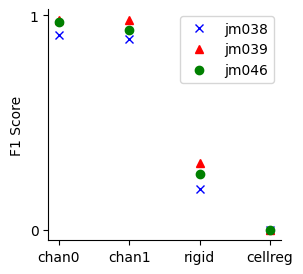

In [265]:
# Chemins des fichiers NumPy
base_path = '/Volumes/data_jm_share/data_proc/jm'  # Remplacez par le chemin correct
conditions = ['chan0', 'chan1', 'rigid', 'cellreg']
animals = ['jm038', 'jm039', 'jm046']
symbols = {'jm038': 'x', 'jm039': '^', 'jm046': 'o'}
colors = {'jm038': 'blue', 'jm039': 'red', 'jm046': 'green'}


f1_values = {animal: [] for animal in animals}


for animal in animals:
    for condition in conditions:
        metrics = np.load(os.path.join(base_path, animal, condition,'metrics_t2p_all_days.npy'), allow_pickle=True)
        f1_value = metrics[np.where(metrics[:, 0] == 'F1')[0][0], 1]
        f1_values[animal].append(f1_value)
plt.figure(figsize=(3, 3))
for animal in animals:
    plt.plot(conditions, f1_values[animal], symbols[animal], label=animal, color=colors[animal])


plt.ylabel('F1 Score')
plt.yticks([0, 1])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.show()

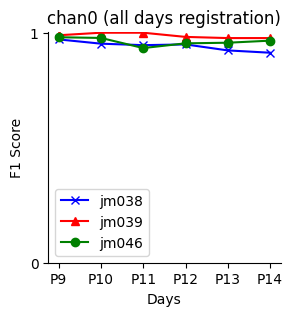

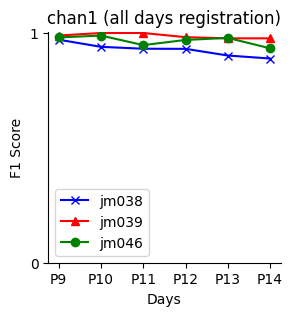

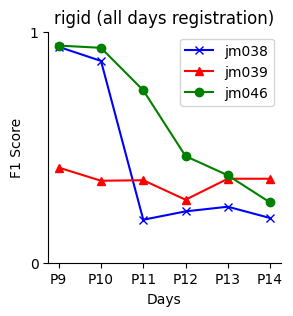

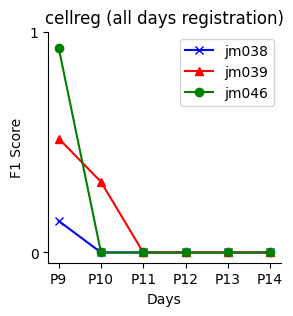

In [43]:
# Chemins des fichiers NumPy
base_path = '/Volumes/data_jm_share/data_proc/jm'  # Remplacez par le chemin correct
conditions = ['chan0', 'chan1', 'rigid', 'cellreg']
animals = ['jm038', 'jm039', 'jm046']
symbols = {'jm038': 'x', 'jm039': '^', 'jm046': 'o'}
colors = {'jm038': 'blue', 'jm039': 'red', 'jm046': 'green'}


for condition in conditions:
    plt.figure(figsize=(3, 3))
    plt.title(f'{condition} (all days registration)')
    plt.xlabel('Days')
    plt.ylabel('F1 Score')

    # Parcourir chaque animal
    for animal in animals:
        file_path = os.path.join(base_path, animal, condition, 'metrics_table_pairs.npy')
        metrics = np.load(file_path, allow_pickle=True)

        f1_scores = metrics[7, 1:].astype(float)

        # Tracer les valeurs F1
        days = np.arange(1, len(f1_scores) + 1)
        plt.plot(days, f1_scores, label=animal, marker=symbols[animal], color=colors[animal])

    plt.yticks([0, 1])
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.xticks(days, [ 'P9', 'P10', 'P11', 'P12', 'P13', 'P14'])
    plt.legend()
    plt.show()



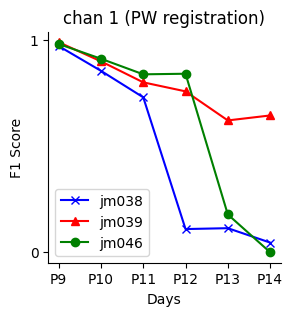

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Chemins des fichiers NumPy
base_path = '/Volumes/data_jm_share/data_proc/jm'  # Remplacez par le chemin correct
animals = ['jm038', 'jm039', 'jm046']
symbols = {'jm038': 'x', 'jm039': '^', 'jm046': 'o'}
colors = {'jm038': 'blue', 'jm039': 'red', 'jm046': 'green'}

plt.figure(figsize=(3, 3))
plt.title('chan 1 (PW registration)')
plt.xlabel('Days')
plt.ylabel('F1 Score')

# Parcourir chaque animal
for animal in animals:
    file_path = os.path.join(base_path, animal, 'metrics_table_pw_registration.npy')
    metrics = np.load(file_path, allow_pickle=True)

    # Extraire les valeurs F1
    f1_scores = metrics[7, 1:].astype(float)  # La ligne 7 contient les valeurs F1, à partir de la deuxième colonne

    # Tracer les valeurs F1
    days = np.arange(1, len(f1_scores) + 1)
    plt.plot(days, f1_scores, label=animal, marker=symbols[animal], color=colors[animal])

plt.yticks([0, 1])
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(days, [ 'P9', 'P10', 'P11', 'P12', 'P13', 'P14'])
plt.legend()
plt.show()


In [50]:
base_path = '/Volumes/data_jm_share/data_proc/jm/jm038' 
days = ['9', '10', '11', '12', '13', '14']

for i, j in enumerate(days): 
    t2p_path = os.path.join(base_path, f't2p_P8_{j}')
    track_ops_dict = np.load(os.path.join(t2p_path, 'track2p', 'track_ops.npy'), allow_pickle=True).item()
    track_ops = SimpleNamespace(**track_ops_dict) # create dummy object from the track_ops dictionary
    print(track_ops.reg_chan)

1
1
1
1
1
1
